# Predicting Uganda Treasury Bill Auction Yields 

# Section 1: Loading  

**1.0 Loading supporting Libs**

In [ ]:
import pandas as pd
import numpy as np

# ==== Section 2: Visualisation & Exploratory Data Analysis ====
import matplotlib.pyplot as plt
import seaborn as sns

# Nice default style for presentations/reports
sns.set(style="whitegrid", context="talk")


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


**1.1 Load raw CSVs**

In [ ]:
paths = {
    "t91": "data/91.csv",
    "t182": "data/182.csv",
    "t364": "data/364.csv",
    "secondary_2023": "data/secondary_from_2023.csv",
    "secondary_upto_2022": "data/secondary_upto_2022.csv",
}

dfs_raw = {k: pd.read_csv(v) for k, v in paths.items()}

**1.2 Shared helpers (for all datasets)**

-- Standardise column names & drop junk columns:

In [ ]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.replace("\n", " ", regex=False).str.strip()
    return df

def drop_empty_unnamed_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    empty_cols = [c for c in df.columns if c.startswith("Unnamed") and df[c].isna().all()]
    return df.drop(columns=empty_cols)


**Parse dates & numeric strings:**

In [ ]:
# def parse_date_col(series: pd.Series) -> pd.Series:
    # return pd.to_datetime(series, dayfirst=True, errors="coerce")

def parse_date_col(series: pd.Series) -> pd.Series:
    """
    Robust date parser for messy BoU-style columns.
    - Tries several explicit string formats
    - Then tries Excel serial-like integers
    - Leaves unparseable values as NaT
    """
    # Work on a clean string view
    s = series.astype("string").str.strip()

    # Initialise everything as NaT
    parsed = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")

    # 1. Try explicit known date formats
    formats = [
        "%d-%b-%y",   # 04-Jul-01
        "%d-%b-%Y",   # 04-Jul-2001
        "%d-%m-%Y",   # 04-07-2001
        "%d/%m/%Y",   # 04/07/2001
        "%Y-%m-%d",   # 2001-07-04
    ]

    for fmt in formats:
        # Only try to parse where we still have NaT
        mask = parsed.isna()
        if not mask.any():
            break

        try:
            dt = pd.to_datetime(s[mask], format=fmt, errors="coerce")
        except Exception:
            continue

        parsed.loc[mask] = dt

    # 2. Try Excel serial numbers (e.g. 44168) where still NaT
    #    These often appear when Excel date cells were exported as numbers
    mask = parsed.isna() & s.str.fullmatch(r"\d+").fillna(False)
    if mask.any():
        serial = pd.to_numeric(s[mask], errors="coerce")
        parsed.loc[mask] = pd.to_datetime(serial, unit="D", origin="1899-12-30")

    # Any weird garbage like '#REF!' remains NaT, which is fine.
    return parsed


def clean_numeric(series: pd.Series) -> pd.Series:
    """Convert mixed/dirty numeric series into floats with NaNs where not parseable."""
    try:
        s = series.astype("string")
        s = s.str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})
        s = s.str.replace(",", "", regex=False)
        s = s.str.replace("%", "", regex=False)
        s = s.str.replace(r"\((.*)\)", r"-\1", regex=True)
        return pd.to_numeric(s, errors="coerce")
    except Exception:
        # Fallback: attempt direct numeric conversion
        return pd.to_numeric(series, errors="coerce")


# **Section 2: Cleaning the auction datasets (91, 182, 364)**
**2.1 Auction cleaning function**

In [37]:
def clean_auction_df(df: pd.DataFrame, tenor: str) -> pd.DataFrame:
    df = df.copy()
    df = standardize_columns(df)
    df = drop_empty_unnamed_columns(df)
    df = df.dropna(how="all")   # drop fully empty rows

    # Map original labels → modeling-friendly names
    base_mapping = {
        "Auction No": "auction_no",
        "Issue date": "issue_date",
        "Amount offered in Auction": "amount_offered",
        "Amount offered": "amount_offered",
        "Total bids (Competitive & Uncompetitive)": "total_bids",
        "Total bids (competitive & non)": "total_bids",
        "Total bids": "total_bids",
        "Over/(Under) Subscribed": "over_under_subscribed",
        "Over/(Under) subscribed": "over_under_subscribed",
        "Face Value of Issues": "face_value",
        "Face Value": "face_value",
        "Cost Value": "cost_value",
        "Interest due": "interest_due",
        "Date due": "date_due",
        "Duration": "duration_days",
        "Implicit annual": "implicit_annual_yield",
        "Clearing": "cutoff_yield",
        "Lowest Factor (%)": "lowest_factor_pct",
        "Lowest": "lowest_yield",
        "Weighted Average Price": "weighted_avg_price",
        "Weighted average price": "weighted_avg_price",
        "Weighted Average": "weighted_avg_yield",
        "Average Discount": "average_discount",
        "Average discount factor": "average_discount_factor",
        "Money Market yield": "money_market_yield",
        "Money Market": "money_market_yield",
        "Money market yielr": "money_market_yield",
        "Annualised": "annualised_yield",
        "Rejected Amount": "rejected_amount",
        "Bid to cover ratios": "bid_to_cover",
        "Bid-to-cover": "bid_to_cover",
    }

    rename_map = {}
    for col in df.columns:
        col_clean = col.replace("\n", " ").strip()
        if col_clean in base_mapping:
            rename_map[col] = base_mapping[col_clean]

    df = df.rename(columns=rename_map)

    # Drop rows without auction number (blank/junk rows)
    if "auction_no" in df.columns:
        df = df[df["auction_no"].notna()]

    # Date columns
    for date_col in ["issue_date", "date_due"]:
        if date_col in df.columns:
            df[date_col] = parse_date_col(df[date_col])

    # Numeric columns
    numeric_cols = [
        "auction_no",
        "amount_offered",
        "total_bids",
        "over_under_subscribed",
        "face_value",
        "cost_value",
        "interest_due",
        "duration_days",
        "implicit_annual_yield",
        "cutoff_yield",
        "lowest_factor_pct",
        "lowest_yield",
        "weighted_avg_price",
        "weighted_avg_yield",
        "average_discount",
        "average_discount_factor",
        "money_market_yield",
        "annualised_yield",
        "rejected_amount",
        "bid_to_cover",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = clean_numeric(df[col])

    # Add tenor label
    df["tenor_days"] = int(tenor)

    return df.reset_index(drop=True)


In [38]:
print ("DATAFRAME SHAPES ")
print (f"91 days Treasuary Bills (RxC): ", t91_clean.shape)
print (f"182 days Treasuary Bills (RxC): ",t182_clean.shape)
print (f"364 days Treasuary Bills: (RxC)", t364_clean.shape)

DATAFRAME SHAPES 
91 days Treasuary Bills (RxC):  (450, 20)
182 days Treasuary Bills (RxC):  (808, 20)
364 days Treasuary Bills: (RxC) (1042, 20)


**2.2 Apply to each tenor**

In [39]:
t91_clean  = clean_auction_df(dfs_raw["t91"],  tenor="91")
t182_clean = clean_auction_df(dfs_raw["t182"], tenor="182")
t364_clean = clean_auction_df(dfs_raw["t364"], tenor="364")

# Section 3: Cleaning the secondary market datasets
 **3.1 Secondary cleaning function**

In [40]:
def clean_secondary_df(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = df.copy()
    df = standardize_columns(df)
    df = drop_empty_unnamed_columns(df)
    df = df.dropna(how="all")

    rename_map = {}
    for col in df.columns:
        col_clean = col.strip()
        if col_clean == "DATE":
            rename_map[col] = "date"
        elif col_clean == "FACE VALUE":
            rename_map[col] = "face_value"
        elif "Agreed" in col_clean and "Cost" in col_clean:
            rename_map[col] = "agreed_cost"
        elif col_clean in ("Security", "SECURITY/"):
            rename_map[col] = "security"
    df = df.rename(columns=rename_map)

    # Parse date
    if "date" in df.columns:
        df["date"] = parse_date_col(df["date"])

    # Numeric fields
    for col in ["face_value", "agreed_cost"]:
        if col in df.columns:
            df[col] = clean_numeric(df[col])

    # Keep track of origin (upto 2022 vs from 2023)
    df["source_label"] = label

    return df.reset_index(drop=True)


**3.2 Apply & combine secondary files**

In [41]:
secondary_2023_clean      = clean_secondary_df(dfs_raw["secondary_2023"],      label="from_2023")
secondary_upto_2022_clean = clean_secondary_df(dfs_raw["secondary_upto_2022"], label="upto_2022")

secondary_all_clean = (
    pd.concat([secondary_upto_2022_clean, secondary_2023_clean], ignore_index=True)
    .sort_values("date")
    .reset_index(drop=True)
)


In [42]:
print ("SECONDARY MARKET SHAPES ")
print (f"91 days Treasuary Bills (ROWxCOLUMN): ", secondary_all_clean.shape)

SECONDARY MARKET SHAPES 
91 days Treasuary Bills (ROWxCOLUMN):  (80853, 10)


# 🧩 Section 4 – Setup Plotting & Quick EDA (Data Engineering)

**4.1 Basic EDA: cutoff yields over time per tenor**

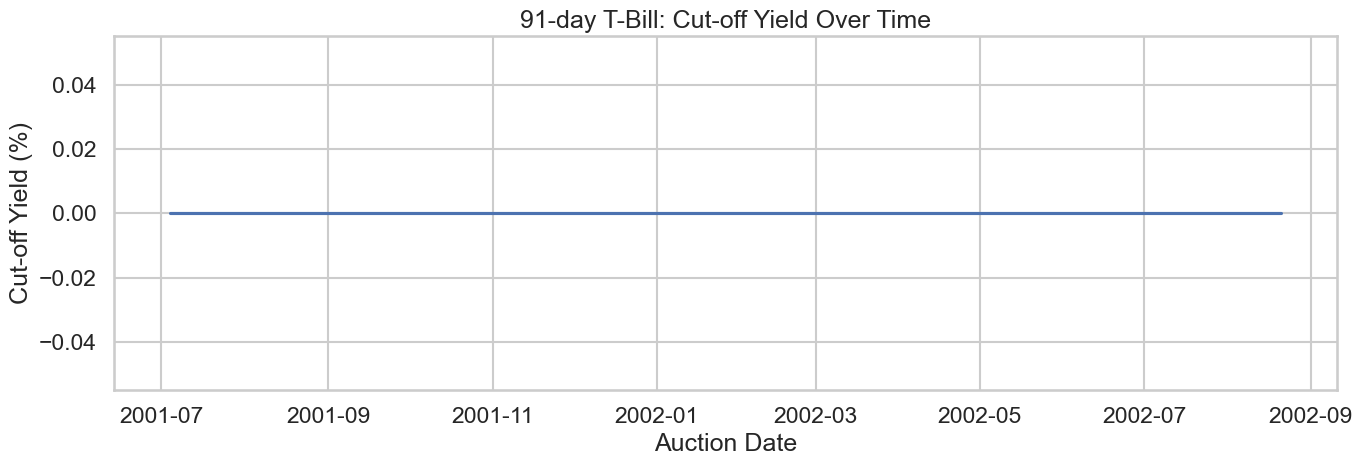

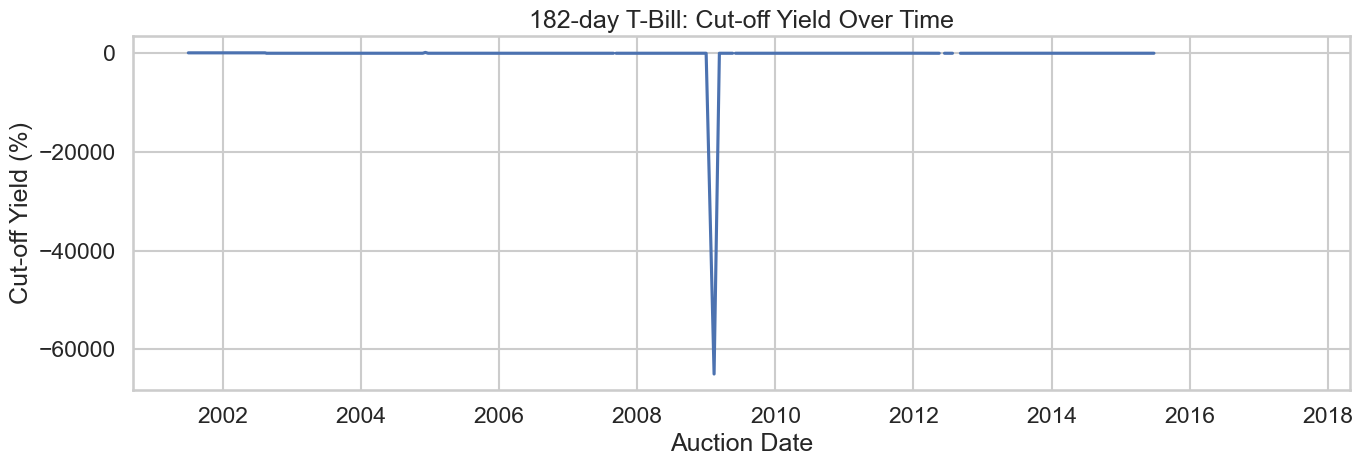

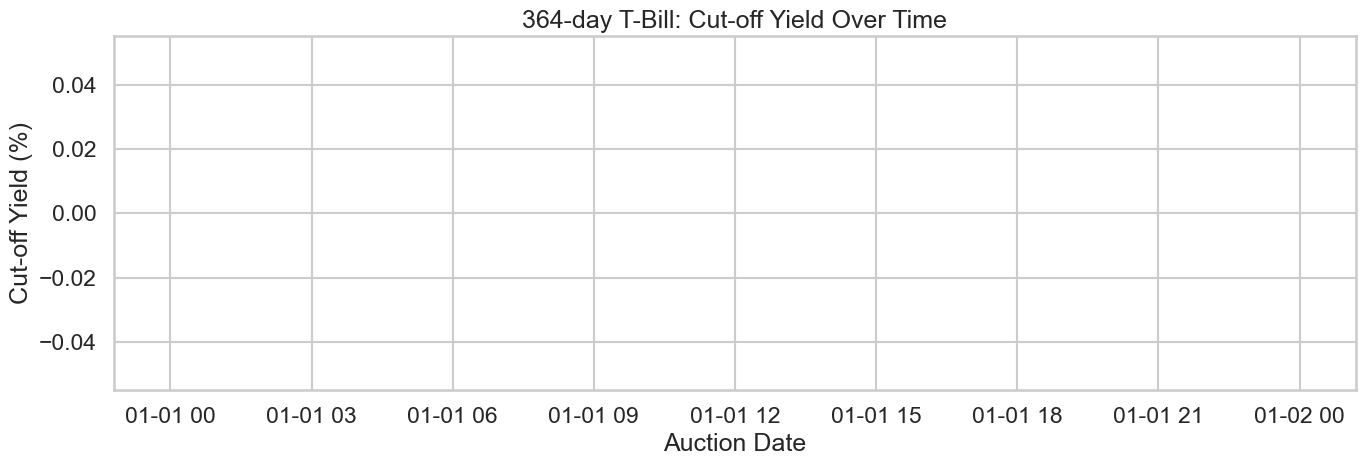

In [46]:
# Quick helper to plot a time series for any tenor
def plot_yield_timeseries(df, tenor_label):
    plt.figure(figsize=(14, 5))
    plt.plot(df["issue_date"], df["cutoff_yield"])
    plt.title(f"{tenor_label} T-Bill: Cut-off Yield Over Time")
    plt.xlabel("Auction Date")
    plt.ylabel("Cut-off Yield (%)")
    plt.tight_layout()
    plt.show()

plot_yield_timeseries(t91_clean,  "91-day")
plot_yield_timeseries(t182_clean, "182-day")
plot_yield_timeseries(t364_clean, "364-day")


**4.2 – Distribution of yields and bid-to-cover (by tenor)**

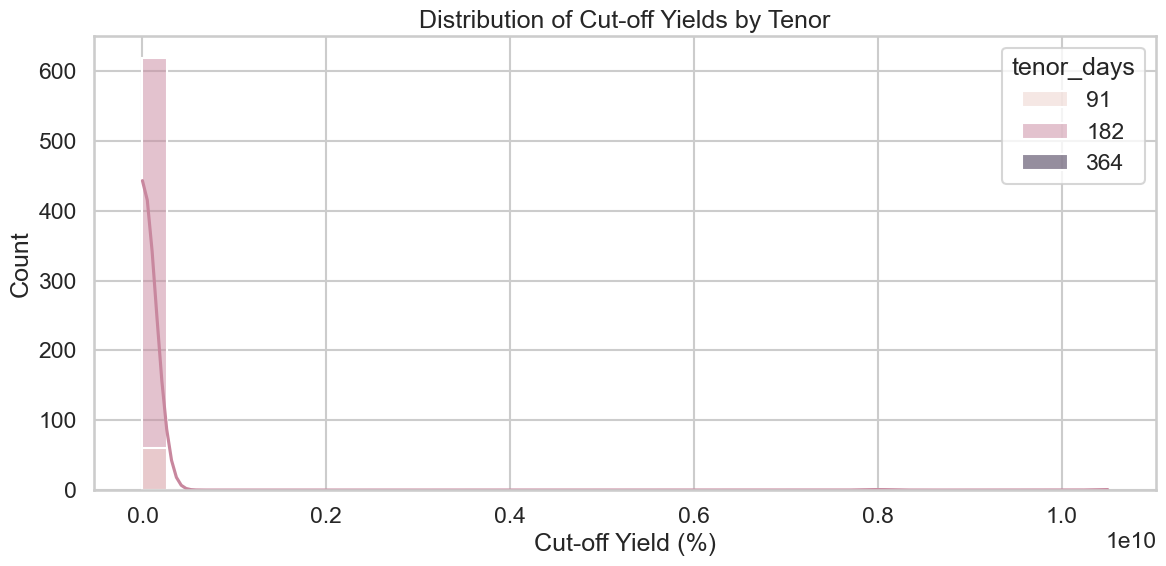

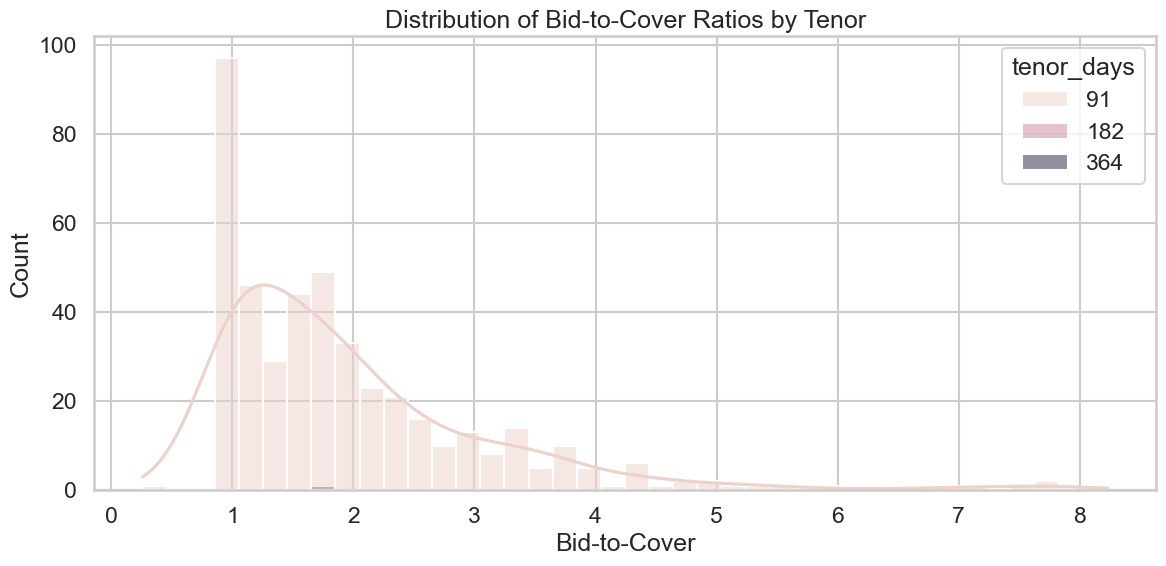

In [51]:
# Add a tenor label temporarily for simple stacked EDA
t91_eda  = t91_clean.assign(tenor_days=91)
t182_eda = t182_clean.assign(tenor_days=182)
t364_eda = t364_clean.assign(tenor_days=364)

eda_all = pd.concat([t91_eda, t182_eda, t364_eda], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.histplot(
    data=eda_all,
    x="cutoff_yield",
    hue="tenor_days",
    kde=True,
    bins=40
)
plt.title("Distribution of Cut-off Yields by Tenor")
plt.xlabel("Cut-off Yield (%)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(
    data=eda_all,
    x="bid_to_cover",
    hue="tenor_days",
    kde=True,
    bins=40
)
plt.title("Distribution of Bid-to-Cover Ratios by Tenor")
plt.xlabel("Bid-to-Cover")
plt.tight_layout()
plt.show()


# 🧩 Section 5 – Build Unified Auction Panel (Data Engineering)
**This is the base we’ll use for feature engineering and modeling.**

In [52]:
# ==== Section 3: Unified Auction Panel ====

# Define the modeling columns we care about
auction_cols = [
    "auction_no",
    "issue_date",
    "tenor_days",
    "amount_offered",
    "total_bids",
    "over_under_subscribed",
    "face_value",
    "cost_value",
    "interest_due",
    "duration_days",
    "implicit_annual_yield",
    "cutoff_yield",          # main target
    "lowest_factor_pct",
    "lowest_yield",
    "weighted_avg_price",
    "weighted_avg_yield",
    "average_discount",
    "average_discount_factor",
    "money_market_yield",
    "annualised_yield",
    "rejected_amount",
    "bid_to_cover",
]

def select_auction_cols(df):
    cols_present = [c for c in auction_cols if c in df.columns]
    return df[cols_present].copy()

t91_m  = select_auction_cols(t91_clean)
t182_m = select_auction_cols(t182_clean)
t364_m = select_auction_cols(t364_clean)

# Concatenate all tenors into a long panel
auctions_all = pd.concat([t91_m, t182_m, t364_m], ignore_index=True)

# Drop rows with missing key fields
auctions_all = auctions_all[auctions_all["issue_date"].notna()]
auctions_all = auctions_all[auctions_all["cutoff_yield"].notna()]

# Sort by tenor and date
auctions_all = auctions_all.sort_values(["tenor_days", "issue_date"]).reset_index(drop=True)

# Create a clearly named target (both percent and basis points)
auctions_all["y_cutoff_pct"] = auctions_all["cutoff_yield"]
auctions_all["y_cutoff_bp"]  = auctions_all["cutoff_yield"] * 100  # 10.5% -> 1050bp

auctions_all.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,average_discount,money_market_yield,annualised_yield,bid_to_cover,lowest_yield,average_discount_factor,rejected_amount,weighted_avg_yield,y_cutoff_pct,y_cutoff_bp
0,469.0,2001-07-04,91,1500000000.0,2402100000.0,902100000.0,1500000000.0,1473850685.0,26149315,91.0,...,6.992,<NA>,7.116,1.601,<NA>,<NA>,<NA>,<NA>,0.0,0.0
1,470.0,2001-07-11,91,2000000000.0,6763900000.0,4763900000.0,2000000000.0,1966357750.0,33642250,91.0,...,6.747,<NA>,6.862,3.382,<NA>,<NA>,<NA>,<NA>,0.0,0.0
2,471.0,2001-07-18,91,2000000000.0,3562000000.0,1562000000.0,2000000000.0,1964154360.0,35845640,91.0,...,7.189,<NA>,7.32,1.781,<NA>,<NA>,<NA>,<NA>,0.0,0.0
3,472.0,2001-07-25,91,3000000000.0,3034500000.0,34500000.0,3000000000.0,2920291115.0,79708885,91.0,...,10.657,<NA>,10.948,1.012,<NA>,<NA>,<NA>,<NA>,0.0,0.0
4,473.0,2001-08-01,91,3000000000.0,3000000000.0,<NA>,3000000000.0,2899532650.0,100467350,91.0,...,13.432,<NA>,13.898,1.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0


At this point, we have a single dataset with one row per auction per tenor and a clear target variable.

# Section 6 – Feature Engineering: Lags & Rolling Stats

**6.1 Generated history-based features per tenor (ex-ante information only).**

In [53]:
# ==== Section 4: Feature Engineering - Lags & Rolling Features ====

def add_lag_features(df, group_col="tenor_days", sort_col="issue_date"):
    """
    Add lagged and rolling-window features per tenor.
    These use only past information (shifted), so they are safe for forecasting.
    """
    df = df.sort_values([group_col, sort_col]).copy()

    # 1-lag features (previous auction of same tenor)
    df["lag1_cutoff"]     = df.groupby(group_col)["cutoff_yield"].shift(1)
    df["lag1_bid_to_cov"] = df.groupby(group_col)["bid_to_cover"].shift(1)
    df["lag1_total_bids"] = df.groupby(group_col)["total_bids"].shift(1)

    # Rolling features for cut-off yield (3 and 5 previous auctions)
    df["roll3_cutoff_mean"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
    )
    df["roll3_cutoff_std"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())
    )

    df["roll5_cutoff_mean"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    )
    df["roll5_cutoff_std"] = (
        df.groupby(group_col)["cutoff_yield"]
          .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).std())
    )

    # Rolling demand pressure via bid-to-cover
    if "bid_to_cover" in df.columns:
        df["roll3_btc_mean"] = (
            df.groupby(group_col)["bid_to_cover"]
              .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
        )
        df["roll3_btc_std"] = (
            df.groupby(group_col)["bid_to_cover"]
              .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())
        )

    return df

auctions_fe = add_lag_features(auctions_all)
auctions_fe.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,y_cutoff_bp,lag1_cutoff,lag1_bid_to_cov,lag1_total_bids,roll3_cutoff_mean,roll3_cutoff_std,roll5_cutoff_mean,roll5_cutoff_std,roll3_btc_mean,roll3_btc_std
0,469.0,2001-07-04,91,1500000000.0,2402100000.0,902100000.0,1500000000.0,1473850685.0,26149315,91.0,...,0.0,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
1,470.0,2001-07-11,91,2000000000.0,6763900000.0,4763900000.0,2000000000.0,1966357750.0,33642250,91.0,...,0.0,0.0,1.601,2402100000.0,0.0,NaN,0.0,NaN,1.601000,NaN
2,471.0,2001-07-18,91,2000000000.0,3562000000.0,1562000000.0,2000000000.0,1964154360.0,35845640,91.0,...,0.0,0.0,3.382,6763900000.0,0.0,0.0,0.0,0.0,2.491500,1.259357
3,472.0,2001-07-25,91,3000000000.0,3034500000.0,34500000.0,3000000000.0,2920291115.0,79708885,91.0,...,0.0,0.0,1.781,3562000000.0,0.0,0.0,0.0,0.0,2.254667,0.980439
4,473.0,2001-08-01,91,3000000000.0,3000000000.0,<NA>,3000000000.0,2899532650.0,100467350,91.0,...,0.0,0.0,1.012,3034500000.0,0.0,0.0,0.0,0.0,2.058333,1.209095


**6.2 – Visualise raw vs rolling yields for one tenor**

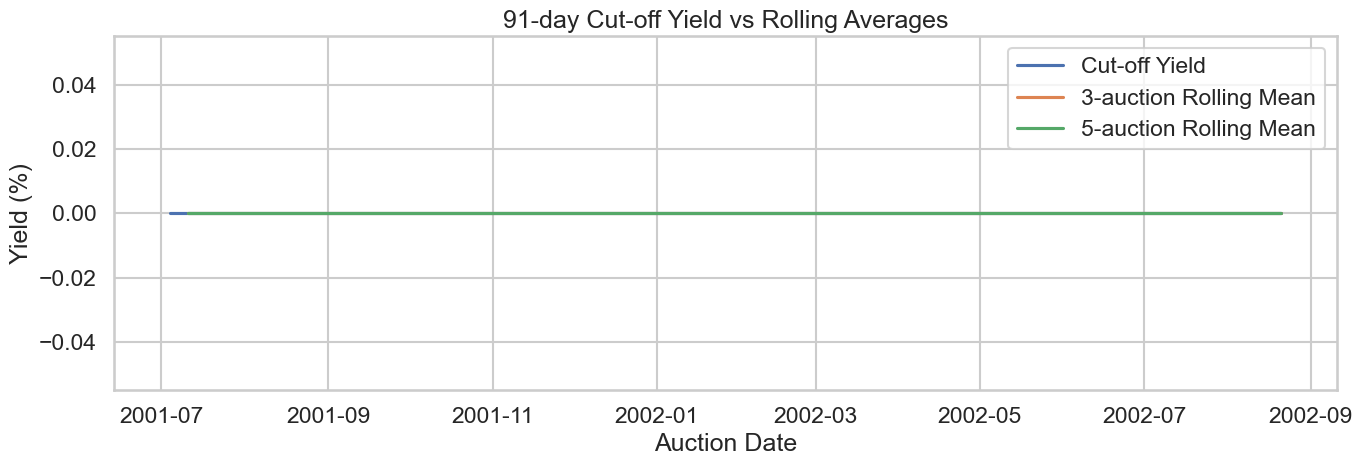

In [54]:
# Example: show the effect of rolling features for 91-day tenor
mask_91 = auctions_fe["tenor_days"] == 91
sub_91 = auctions_fe.loc[mask_91].sort_values("issue_date")

plt.figure(figsize=(14, 5))
plt.plot(sub_91["issue_date"], sub_91["cutoff_yield"], label="Cut-off Yield")
plt.plot(sub_91["issue_date"], sub_91["roll3_cutoff_mean"], label="3-auction Rolling Mean")
plt.plot(sub_91["issue_date"], sub_91["roll5_cutoff_mean"], label="5-auction Rolling Mean")
plt.title("91-day Cut-off Yield vs Rolling Averages")
plt.xlabel("Auction Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.tight_layout()
plt.show()


# Section 7 – Yield Curve Features (Spreads Across Tenors)

**Now we derive curve structure: how 91/182/364 relate to each other at each auction date.**


# 🧩 Section 8 – Calendar / Seasonality Features
Auctions can have seasonal patterns (month-end, quarter-end, fiscal year, etc.). We encode simple calendar features here

In [58]:
# ==== Section 6: Calendar & Seasonality Features ====

df = auctions_fe.copy()

df["year"]        = df["issue_date"].dt.year
df["month"]       = df["issue_date"].dt.month
df["day_of_week"] = df["issue_date"].dt.weekday  # 0=Mon, 4=Fri etc.
df["quarter"]     = df["issue_date"].dt.quarter

# Auction index per tenor (1st, 2nd, 3rd,... auction in the history of that tenor)
df["auction_index"] = (
    df.sort_values(["tenor_days", "issue_date"])
      .groupby("tenor_days")
      .cumcount() + 1
)

auctions_fe = df
auctions_fe.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,roll3_cutoff_std,roll5_cutoff_mean,roll5_cutoff_std,roll3_btc_mean,roll3_btc_std,year,month,day_of_week,quarter,auction_index
0,469.0,2001-07-04,91,1500000000.0,2402100000.0,902100000.0,1500000000.0,1473850685.0,26149315,91.0,...,NaN,NaN,NaN,NaN,NaN,2001,7,2,3,1
1,470.0,2001-07-11,91,2000000000.0,6763900000.0,4763900000.0,2000000000.0,1966357750.0,33642250,91.0,...,NaN,0.0,NaN,1.601000,NaN,2001,7,2,3,2
2,471.0,2001-07-18,91,2000000000.0,3562000000.0,1562000000.0,2000000000.0,1964154360.0,35845640,91.0,...,0.0,0.0,0.0,2.491500,1.259357,2001,7,2,3,3
3,472.0,2001-07-25,91,3000000000.0,3034500000.0,34500000.0,3000000000.0,2920291115.0,79708885,91.0,...,0.0,0.0,0.0,2.254667,0.980439,2001,7,2,3,4
4,473.0,2001-08-01,91,3000000000.0,3000000000.0,<NA>,3000000000.0,2899532650.0,100467350,91.0,...,0.0,0.0,0.0,2.058333,1.209095,2001,8,2,3,5


**8.1 – Visualise seasonality (example: average yield by month)**

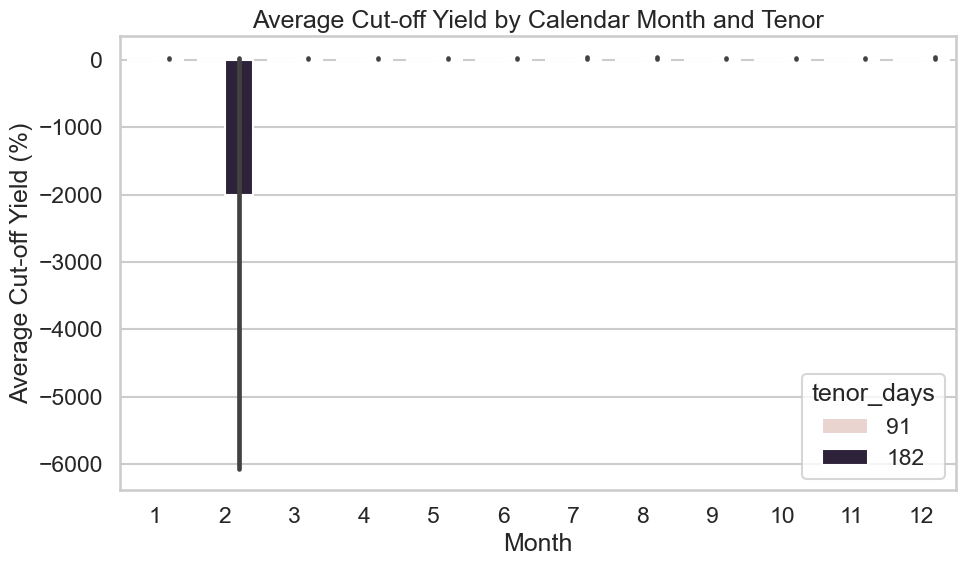

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=auctions_fe,
    x="month",
    y="cutoff_yield",
    hue="tenor_days",
    estimator="mean"
)
plt.title("Average Cut-off Yield by Calendar Month and Tenor")
plt.xlabel("Month")
plt.ylabel("Average Cut-off Yield (%)")
plt.tight_layout()
plt.show()


#  Section 9 – Secondary Market Features (Starter Version)

Simple secondary features: daily volume and rolling sums, then later refine to tenor-specific yields if/when we extract that from the security field.

In [60]:
# ==== Section 7: Secondary Market Aggregation ====
# Objective: build simple liquidity proxies aligned to auction dates.

secondary = secondary_all_clean.copy()

# Basic daily aggregates: total face value and total agreed cost per day
sec_daily = (
    secondary
    .groupby("date")
    .agg(
        sec_total_face_value=("face_value", "sum"),
        sec_total_agreed_cost=("agreed_cost", "sum"),
        sec_trade_count=("face_value", "count"),
    )
    .reset_index()
)

# 7-day rolling sums and averages as liquidity proxies
sec_daily = sec_daily.sort_values("date")
sec_daily["sec_7d_face_value_sum"] = sec_daily["sec_total_face_value"].rolling(window=7, min_periods=1).sum()
sec_daily["sec_7d_trade_count"]    = sec_daily["sec_trade_count"].rolling(window=7, min_periods=1).sum()

# Merge secondary info into auction dataset (using last available info up to auction date)
# Strategy: "as-of" join via merge_asof
auctions_fe = auctions_fe.sort_values("issue_date")
sec_daily   = sec_daily.sort_values("date")

auctions_fe = pd.merge_asof(
    auctions_fe,
    sec_daily,
    left_on="issue_date",
    right_on="date",
    direction="backward"  # use last known secondary data on or before the auction date
)

# Drop the merge helper 'date' column from secondary
auctions_fe = auctions_fe.drop(columns=["date"])

auctions_fe.head()


,auction_no,issue_date,tenor_days,amount_offered,total_bids,over_under_subscribed,face_value,cost_value,interest_due,duration_days,...,year,month,day_of_week,quarter,auction_index,sec_total_face_value,sec_total_agreed_cost,sec_trade_count,sec_7d_face_value_sum,sec_7d_trade_count
0,469.0,2001-07-04,91,1500000000.0,2402100000.0,902100000.0,1500000000.0,1473850685.0,26149315,91.0,...,2001,7,2,3,1,<NA>,<NA>,<NA>,NaN,NaN
1,469.0,2001-07-04,182,1500000000.0,2670000000.0,1170000000.0,1500000000.0,1440153500.0,59846500,182.0,...,2001,7,2,3,1,<NA>,<NA>,<NA>,NaN,NaN
2,470.0,2001-07-11,182,2000000000.0,2030000000.0,30000000.0,2000000000.0,1895843600.0,104156400,182.0,...,2001,7,2,3,2,<NA>,<NA>,<NA>,NaN,NaN
3,470.0,2001-07-11,91,2000000000.0,6763900000.0,4763900000.0,2000000000.0,1966357750.0,33642250,91.0,...,2001,7,2,3,2,<NA>,<NA>,<NA>,NaN,NaN
4,471.0,2001-07-18,182,2000000000.0,3088900000.0,1088900000.0,2000000000.0,1878252919.0,121747081,182.0,...,2001,7,2,3,3,<NA>,<NA>,<NA>,NaN,NaN


8.1 – Visualise relation between secondary activity and yields

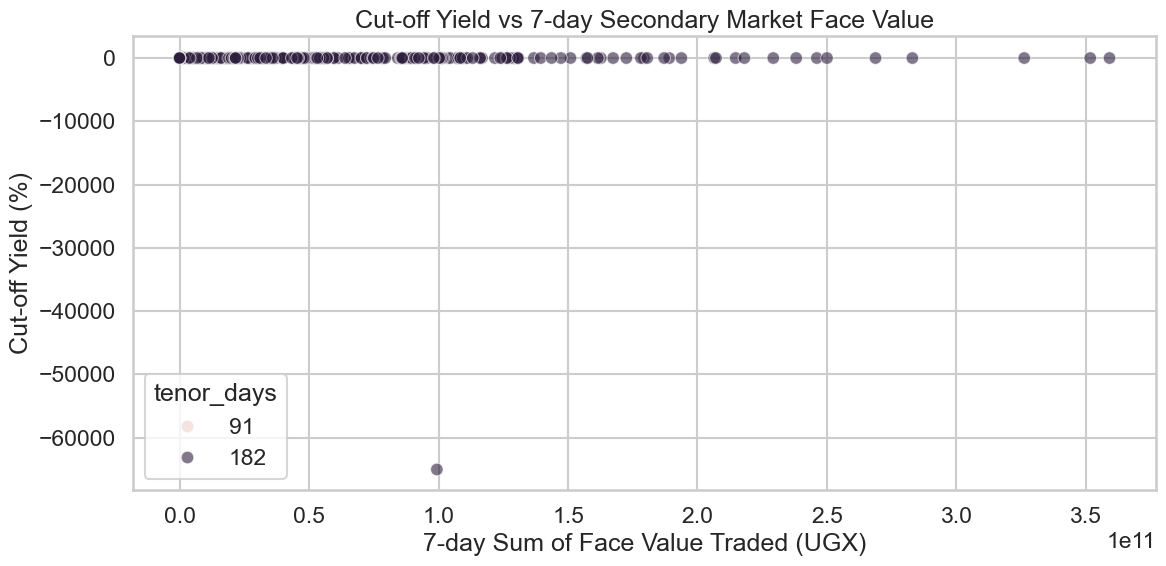

In [62]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=auctions_fe,
    x="sec_7d_face_value_sum",
    y="cutoff_yield",
    hue="tenor_days",
    alpha=0.6
)
plt.title("Cut-off Yield vs 7-day Secondary Market Face Value")
plt.xlabel("7-day Sum of Face Value Traded (UGX)")
plt.ylabel("Cut-off Yield (%)")
plt.tight_layout()
plt.show()


# Section 9 – Modeling Setup

In [63]:
# ==== Section 9: Modeling Setup ====

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Helper: compute directional accuracy (did model get direction of movement right?)
def directional_accuracy(y_true, y_pred):
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    return (direction_true == direction_pred).mean() * 100


In [ ]:
# Section 10 – Prepare Modeling Dataset

KeyError: ['spread_364_91', 'spread_364_182', 'spread_182_91']